<a href="https://colab.research.google.com/github/Melikakmm/GPR_fitting_interactive_potential/blob/main/fitpot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Process regression for fitting interatomic potentials

## Workshop Aims
* Data representation using invariant descriptors
* Building covariance matrices for derived quantities - learning from total energy data
* Uncertainty analysis of predicted energy values
* Optimising hyperparameters
* Relaxing geometry using a machine learned potential



In [1]:
!alias gcc='gcc-11'
!alias cc='gcc-11'
!alias g++='g++-11'
!alias c++='c++-11'

In [ ]:
pip install GPy

In [ ]:
pip install ase

In [ ]:
pip install nglview

In [4]:
import numpy as np
import pandas as pd
import GPy

from ase.io import read
import nglview

from IPython.display import display

%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from google.colab import output
output.enable_custom_widget_manager()

Populating the interactive namespace from numpy and matplotlib


In [54]:
custom_style_gold = {
    'axes.labelcolor': 'blue',
    'axes.edgecolor': 'gray',
    'axes.facecolor': '#FFFFF0',
    'xtick.color': 'green',
    'ytick.color': 'red',
    'font.size': 15,
    'legend.fontsize': 12,
    'grid.color': '#E6DAA6',
}


In [6]:
plt.rcParams['figure.figsize'] = [10, 8]

## Part 1
### Learning the interaction energy of a single water molecule

The quantum mechanical energy of a water molecule - within the Born-Oppenheimer approximation - is a function of the geometry of the molecule, i.e. the Cartesian coordinates $\mathbf{r}_\rm{O}$, $\mathbf{r}_{\rm H_1}$ and  $\mathbf{r}_{\rm H_2}$. Of course, this energy does not depend on the orientation of the water molecule if there is no external field interacting with the molecule.

<img src="water.png">

We can rewrite the energy function as $E(\mathbf{r}_{\rm O},\mathbf{r}_{\rm H_1},\mathbf{r}_{\rm H_2}) \equiv E(r_{\rm OH_1},r_{\rm OH_2},\theta_{\rm HOH})$ where $r_{\rm OH}$ are the bond lengths and $\theta_{\rm HOH}$ the bond angle. This description is invariant to rotations and translations. We also know that the 'label' of the hydrogens is unimportant (i.e. swapping $\rm H_1$ and $\rm H_2$ does not change the energy), therefore it is useful to symmetrise the distances.

In this exercise, we will use the following data coordinates:
* $r_+ = r_{\rm OH_1} + r_{\rm OH_2}$
* $r_- = (r_{\rm OH_1} - r_{\rm OH_2})^2$
* $a = \mathbf{r}_{\rm OH_1} \cdot \mathbf{r}_{\rm OH_2}$

### Question 1

**Explain why the descriptor functions $r_+$, $r_-$ and $a$ are invariant to rigid rotations, translations of the molecule and permutations of the hydrogen indices.**

answer: because $\mathbf{r}_{\rm OH_1}$ and $\mathbf{r}_{\rm OH_2}$ vectors are relative positional vectors and are not coming from the origin of the coordinates, they are invariant to rigid rotation and translation of the molecule. because $r_-$ has a power of two, if we swap the hydrogens indeces, nothing will change.






In [7]:
# Read in water configurations
water_configs = read("water_configs.xyz", format="extxyz", index=":")
# There should be 2886 independent water molecules
print(len(water_configs))

2886


In [8]:
# optional - for visualisation
nglview.show_asetraj(water_configs)

NGLWidget(max_frame=2885)

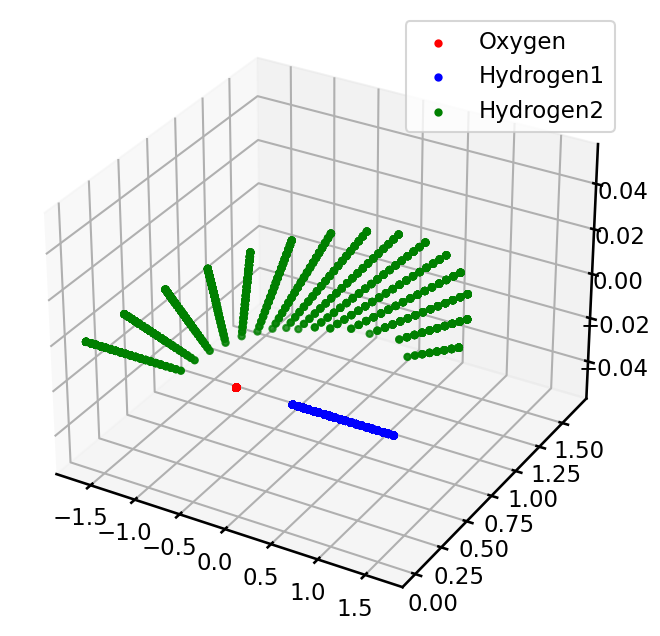

In [15]:
O = []

H1 = []

H2 = []


for a in water_configs:
    p = a.get_positions()
    O.append(p[0])
    H1.append(p[1])
    H2.append(p[2])

coordin = ['x', 'y', 'z']
atoms = ['O', 'H1', 'H2']

for a in atoms:
  exec(f"{a}_x = []")
  exec(f"{a}_y = []")
  exec(f"{a}_z = []")
  atom = globals()[f"{a}"]


  for array in atom:
    globals()[f"{a}_x"].append(array[0])
    globals()[f"{a}_y"].append(array[1])
    globals()[f"{a}_z"].append(array[2])





ax = plt.axes(projection = '3d')
ax.scatter(O_x, O_y, O_z, color = 'red', label = 'Oxygen')
ax.scatter(H1_x, H1_y, H1_z, color = 'blue', label = 'Hydrogen1')
ax.scatter(H2_x, H2_y, H2_z, color = 'green', label = 'Hydrogen2')
ax.legend()



In [9]:
x = [] # input features
y = [] # target values

# Calculating descriptor vectors for each molecule and collect target energies
for a in water_configs:
    p = a.get_positions() # positions: O, H1, H2
    rOH1 = a.get_distance(0, 1)# calculating distance OH1
    rOH2 = a.get_distance(0, 2)# calculating distances OH2
    aHOH = np.dot(p[1]-p[0], p[2]-p[0])# dot product between the vectors OH1 and OH2
    # <Here rOH1 and rOH2 are only distances and aHOH is a dot product of two vectors.>
    x.append([(rOH1 + rOH2), (rOH1 - rOH2)**2, aHOH]) # collect descriptors, they are all scalars.

    y.append(a.get_potential_energy()) # QM energy of a water molecule

We randomly split the data to a train and test set and then use it to train a Gaussian process regression model using `GPy`.

In [70]:
from sklearn.model_selection import train_test_split

# test_size sets the fraction of the test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=1 - 0.2)

X_train = np.array(X_train) # a vector of the 3 descriptors.
y_train = np.array(y_train)[:, None] # GPy needs a 2D array, y_train is a (288, 1) dimensional array of (1,) dimensional arrays

y_train.shape

(577, 1)

The Radial Basis Function (RBF) kernel, also known as the Gaussian kernel, is a popular and widely used kernel function in machine learning and particularly in the context of kernel methods and Gaussian processes. It is used to measure the similarity or distance between data points in a high-dimensional space. The RBF kernel is defined as:

$$ K(x, x') = exp(- {\frac {||x -x'||^2}{2 {σ^2}}})$$

* $K(x, x')$ : This represents the similarity or kernel value between two data points
x and x'.

* $∣∣x−x'∣∣$  : These are vectors representing the data points in a high-dimensional feature space. The RBF kernel measures the similarity between these vectors.

* $σ^2$ : This is a hyperparameter called the `bandwidth` or `lengthscale` parameter. It controls the spread or width of the kernel function. A smaller $σ^2$ results in a narrow kernel with high similarity values for nearby data points, while a larger $σ^2$ results in a wider kernel with similarity values that decay more slowly with distance.

In [71]:
# input_dim: dimensionality of data points - our descriptor vectors have three elements
# variance: range (squared) of the function
print("Range of input data: {:.2f}".format(y_train.max()-y_train.min()))
# lengthscale: characteristic lengthscale - start with a default of 0.5
# ARD: automatic relevance determination - allows separate lengthscales for each three descriptor dimensions

kernel = GPy.kern.Exponential(input_dim=3, variance=1.0, lengthscale=1.0, ARD = True) # ARD : seperate length scale for each input

# the values we chose for the hyperparameters are the initial values.
# they wil be updated during the the optimization.

Range of input data: 17.79


## What is ARD in the code above ?

Using "automatic relevance determination" (ARD) or separate length scales for each input dimension in Gaussian process regression can be useful in certain cases because it allows the model to capture different degrees of influence or importance of each input dimension on the output. This can lead to more `flexible` and `accurate` models in situations where the relationships between inputs and outputs are not isotropic (i.e., the influence of each dimension varies).





### Question 2.a

**Why is it useful to use 'automatic relevance determination' (separate lengthscales, rather than one for all three dimensions) in this situation?** we have chosen ARD to be True eventhough we have used the same length scale for all input dimensions. This is because we want the model to be flexible and understand that these three inputs might have different influeneces on the process.

In [72]:
# Generate a Gaussian Process model by adding training data. Start with a small noise parameter.
m = GPy.models.GPRegression(X_train, y_train, kernel, noise_var=1.)

# the more we decrease the lengthscale, the more the model captures the details.
# it creates a sort of local sensitivity.

In [73]:
# Optimise the likelihood with respect of the hyperparameters of the model
f_values = m.optimize_restarts(num_restarts = 10);

Optimization restart 1/10, f = 339.0775734016996
Optimization restart 2/10, f = 339.077573486128
Optimization restart 3/10, f = 339.0775734006696
Optimization restart 4/10, f = 339.0775734022987
Optimization restart 5/10, f = 339.07757340786856
Optimization restart 6/10, f = 339.0775733976244
Optimization restart 7/10, f = 339.0775734231687
Optimization restart 8/10, f = 339.0775735479029
Optimization restart 9/10, f = 339.07757340559135
Optimization restart 10/10, f = 339.0775733994831


In [15]:
text = """Optimization restart 1/10, f = 931.0150107775701
Optimization restart 2/10, f = -1061.9613246916674
Optimization restart 3/10, f = -1061.9613511910616
Optimization restart 4/10, f = -1061.961309090385
Optimization restart 5/10, f = -1061.9612657697712
Optimization restart 6/10, f = -1061.9614556363367
Optimization restart 7/10, f = -1061.9613604225588
Optimization restart 8/10, f = -1061.961352808683
Optimization restart 9/10, f = -1061.9612862176673
Optimization restart 10/10, f = -1061.961380119029"""








lines = text.split('\n')

# Initialize lists to store restart numbers and f values
restart_numbers = []
f_values = []

# Parse each line to extract restart number and f value
for line in lines:
    parts = line.split(', ')
    restart_part = parts[0].split(' ')
    restart_number = int(restart_part[2].split('/')[0])
    f_value = float(parts[1].split(' ')[-1])

    restart_numbers.append(restart_number)
    f_values.append(f_value)

# Now, you have the lists restart_numbers and f_values containing the extracted values
Res = []
neg_log_like_opt = []

for i, (restart, f) in enumerate(zip(restart_numbers, f_values)):
    Res.append(restart)
    neg_log_like_opt.append(f)
    print(f"Restart {restart}: f = {f}")

Restart 1: f = 931.0150107775701
Restart 2: f = -1061.9613246916674
Restart 3: f = -1061.9613511910616
Restart 4: f = -1061.961309090385
Restart 5: f = -1061.9612657697712
Restart 6: f = -1061.9614556363367
Restart 7: f = -1061.9613604225588
Restart 8: f = -1061.961352808683
Restart 9: f = -1061.9612862176673
Restart 10: f = -1061.961380119029


In [16]:
restart_color = "\033[94m"
f_color = "\033[92m"
reset_color = "\033[0m"


header = f"{restart_color}Restart     |  {f_color}f Value{reset_color}"
separator = "-------------------------------"


print(header)
print(separator)


for restart, f in zip(Res, neg_log_like_opt):

    row = f"{restart_color}Restart {restart:2d}  |  {f_color}f = {f:.4f}{reset_color}"
    print(row)


print(separator)

Restart     |  f Value
-------------------------------
Restart  1  |  f = 931.0150
Restart  2  |  f = -1061.9613
Restart  3  |  f = -1061.9614
Restart  4  |  f = -1061.9613
Restart  5  |  f = -1061.9613
Restart  6  |  f = -1061.9615
Restart  7  |  f = -1061.9614
Restart  8  |  f = -1061.9614
Restart  9  |  f = -1061.9613
Restart 10  |  f = -1061.9614
-------------------------------


In this code, f represents the optimized value of the objective function (often the negative log likelihood). This value is minimized during the hyperparameter optimization process. The smaller the value of f, the better the model's hyperparameters fit the training data.

In practice, f can be useful for comparing the quality of different hyperparameter configurations or for monitoring the progress of the optimization process. A lower f indicates a better fit to the data. However, the exact interpretation and scaling of f can depend on the specific Gaussian Process library or optimization algorithm you are using.

### Question 2.b

**When optimising the hyperparameters, what do we mean by restarts and why is it useful to do more than one?**

a "restart" refers to the process of initializing the optimization algorithm multiple times from different initial points. Each of these initial points is randomly chosen or selected according to some predefined strategy.


The motivation behind using multiple restarts is to improve the chances of finding the global optimum or a better local optimum in non-convex optimization problems

In [74]:
# Print the result of the likelihood optimisation
display(m)
m.rbf.lengthscale


GP_regression.,value,constraints,priors
Exponential.variance,385.6988410041292,+ve,
Exponential.lengthscale,"(3,)",+ve,
Gaussian_noise.variance,1.9662422799477867e-247,+ve,


AttributeError: ignored

`m` contains the trained model: a combination of the _prior_ (in the form of the kernel and its hyperparameters, as well as the noise model) and _data_ (in the form of geometrical descriptors and corresponding energy values).

### Question 2.c

**From the output of the previous cell, what is the noise variance of the optimal model? What does this tell us about the data?**

The noise variance reflects how well the Gaussian process model fits the training data. A lower noise variance indicates that the model fits the data closely, as it implies that the observed data points have less variability around the mean predicted by the GP model.
Conversely, a higher noise variance suggests that there is more variability or uncertainty in the observed data, and the model doesn't fit the data as closely.



In GPR, setting the noise variance too low can lead to overfitting. When the noise variance is underestimated, the model may fit not only the underlying patterns in the data but also the noise itself.
By optimizing the noise variance along with other hyperparameters, we can find a balance that prevents overfitting and provides a more accurate representation of the true underlying process.

In [75]:
from sklearn.metrics import mean_squared_error


# Use the model to predict the energy of water configurations.

y_train_predict, y_train_error = m.predict(np.array(X_train)) # predict energies of training configurations
y_test_predict, y_test_error = m.predict(np.array(X_test))  # predict energies of the test set configurations

# root-mean-square error (RMSE)

mse = mean_squared_error(y_test, y_test_predict[:, 0])
rmse = np.sqrt(mse)


print("RMSE = {:.3f} eV".format(rmse))

RMSE = 0.236 eV


### Question 2.d

**Plot graphs to show the correlation of actual and predicted energies, and of the actual and predicted error**

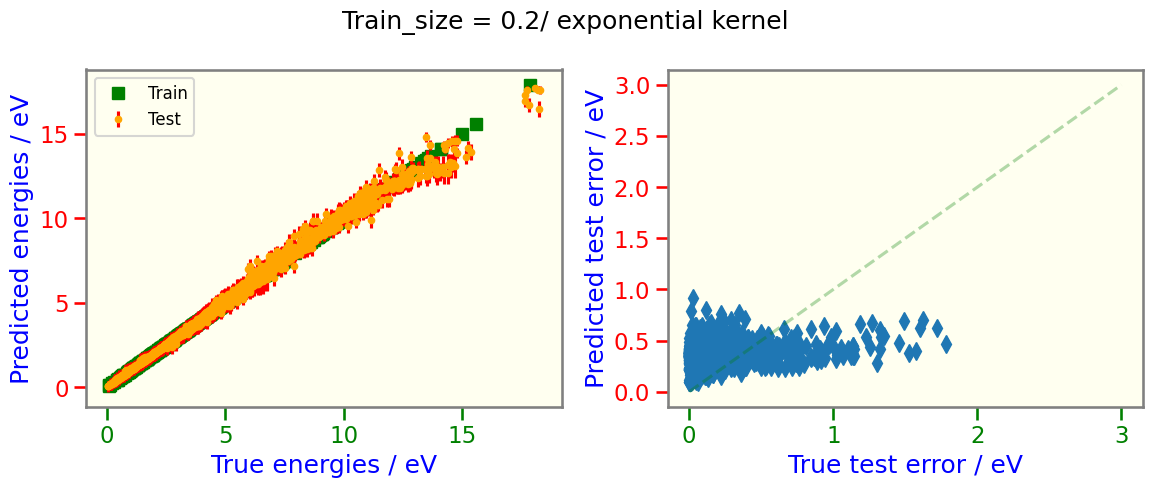

In [77]:
import matplotlib.pyplot as plt

# Create a 1x2 subplot grid
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot true vs. predicted energies
axs[0].plot(y_train, y_train_predict, "s", label='Train', color = 'green')
axs[0].errorbar(y_test, y_test_predict[:, 0], yerr=np.sqrt(y_test_error[:, 0]), fmt=".", label='Test', color = 'orange', ecolor = 'red')
axs[0].set_xlabel('True energies / eV')
axs[0].set_ylabel('Predicted energies / eV')
axs[0].legend()

# Plot the correlation of actual and predicted error
axs[1].plot(np.abs(y_test - y_test_predict[:, 0]), np.sqrt(y_test_error[:, 0]), "d")
axs[1].set_xlabel('True test error / eV')
axs[1].set_ylabel('Predicted test error / eV')
axs[1].plot(range(4), range(4), "--g", alpha = 0.3)
plt.suptitle('Train_size = 0.2/ exponential kernel')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


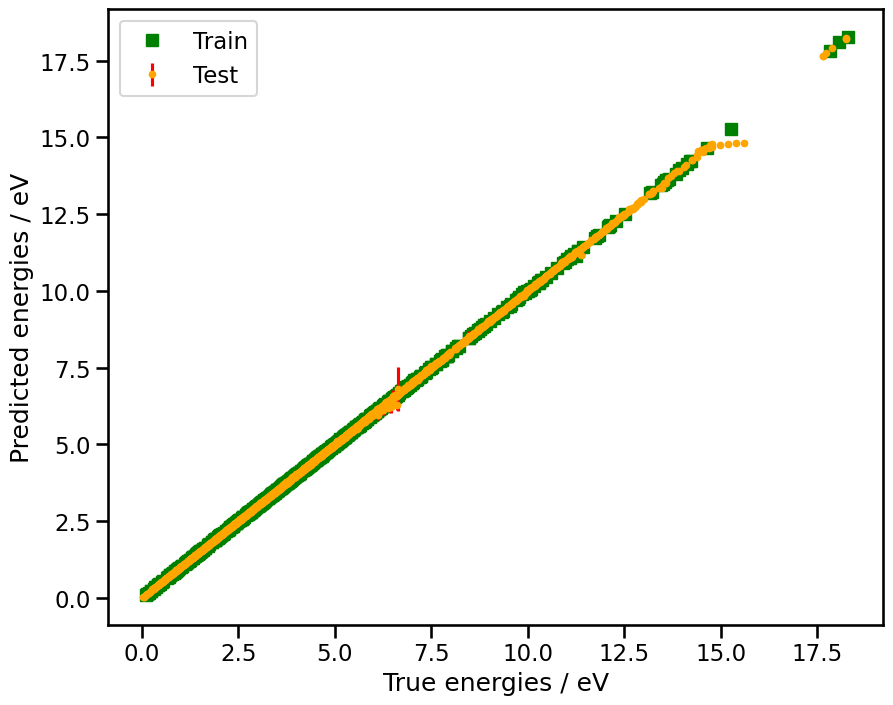

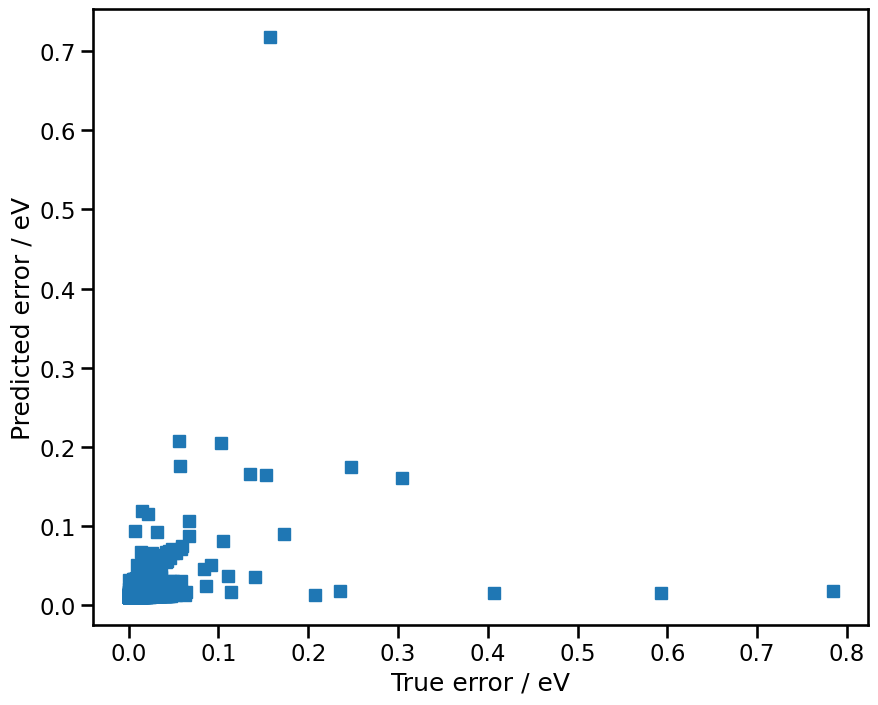

In [20]:
# Plot the correlation of actual and predicted data
plt.plot(y_train,y_train_predict,"s", label='Train', color = 'green')
plt.errorbar(y_test,y_test_predict[:,0],yerr=np.sqrt(y_test_error[:,0]),fmt=".", label='Test', color = 'orange', ecolor = 'red')
plt.xlabel('True energies / eV')
plt.ylabel('Predicted energies / eV')
plt.legend()
plt.show()

# Plot the correlation of actual and predicted error
plt.plot(np.abs(y_test-y_test_predict[:,0]), np.sqrt(y_test_error[:,0]),"s")
plt.xlabel('True error / eV')
plt.ylabel('Predicted error / eV')
plt.show()

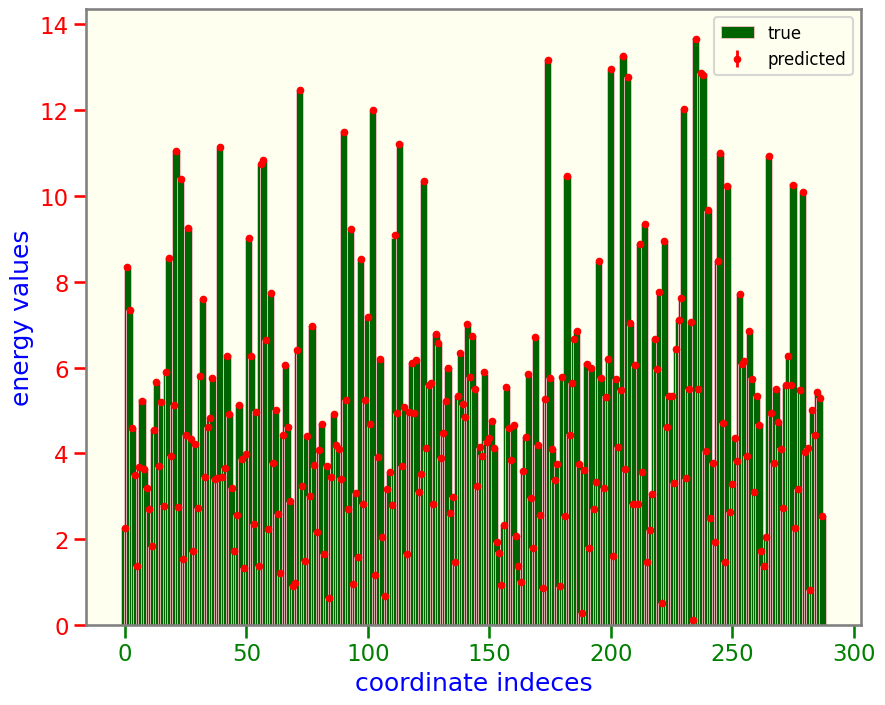

In [30]:
plt.style.use(custom_style_gold)

fig, ax = plt.subplots()
ax.bar(range(288), y_train[:, 0], width = 3, color = 'darkgreen', edgecolor = 'pink', linewidth = 0.6, label = 'true')
ax.errorbar(range(288),y_train_predict[:,0],yerr=y_train_error[:,0],fmt=".",
            color = 'red', elinewidth = 2, label = 'predicted', capsize = 0)

ax.set_xlabel('coordinate indeces')
ax.set_ylabel('energy values')
ax.legend()


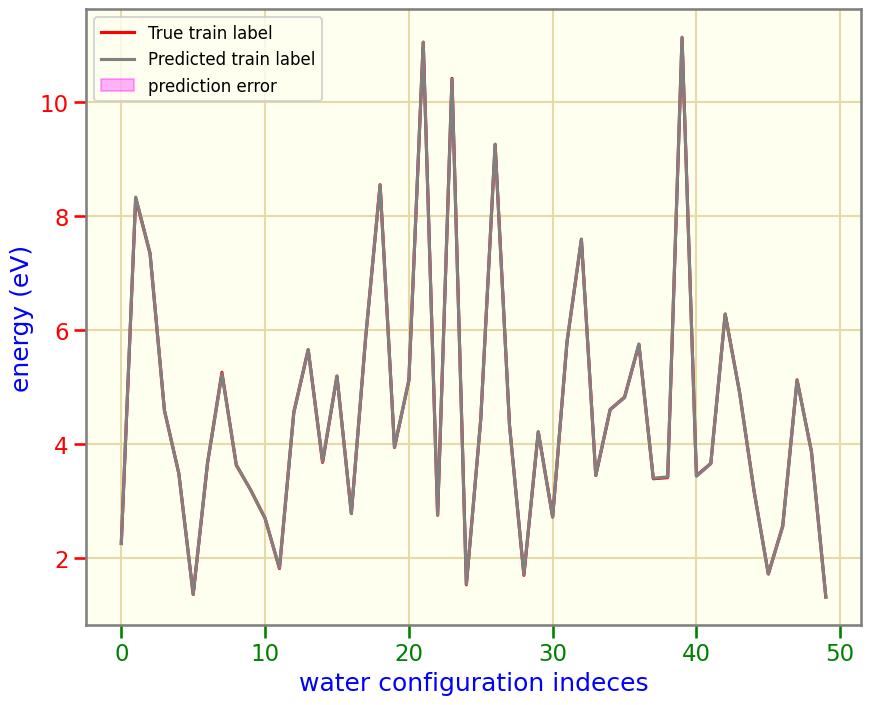

In [31]:
fig, ax = plt.subplots()

ax.plot(range(len(X_train[0:50])), y_train[:, 0][0:50], color = 'red', label = 'True train label')
ax.plot(range(len(X_train[0:50])), y_train_predict[:, 0][0:50], color = 'gray', label = 'Predicted train label')
ax.fill_between(range(len(X_train[0:50])), y_train_predict[:, 0][0:50] - y_train_error[:, 0][0:50], y_train_predict[:, 0][0:50] + y_train_error[:, 0][0:50], color= 'magenta',
                alpha = 0.3, label = 'prediction error')

ax.grid()
ax.legend()
ax.set_xlabel('water configuration indeces')
ax.set_ylabel('energy (eV)')
plt.show()

In [24]:
len(X_train)

288

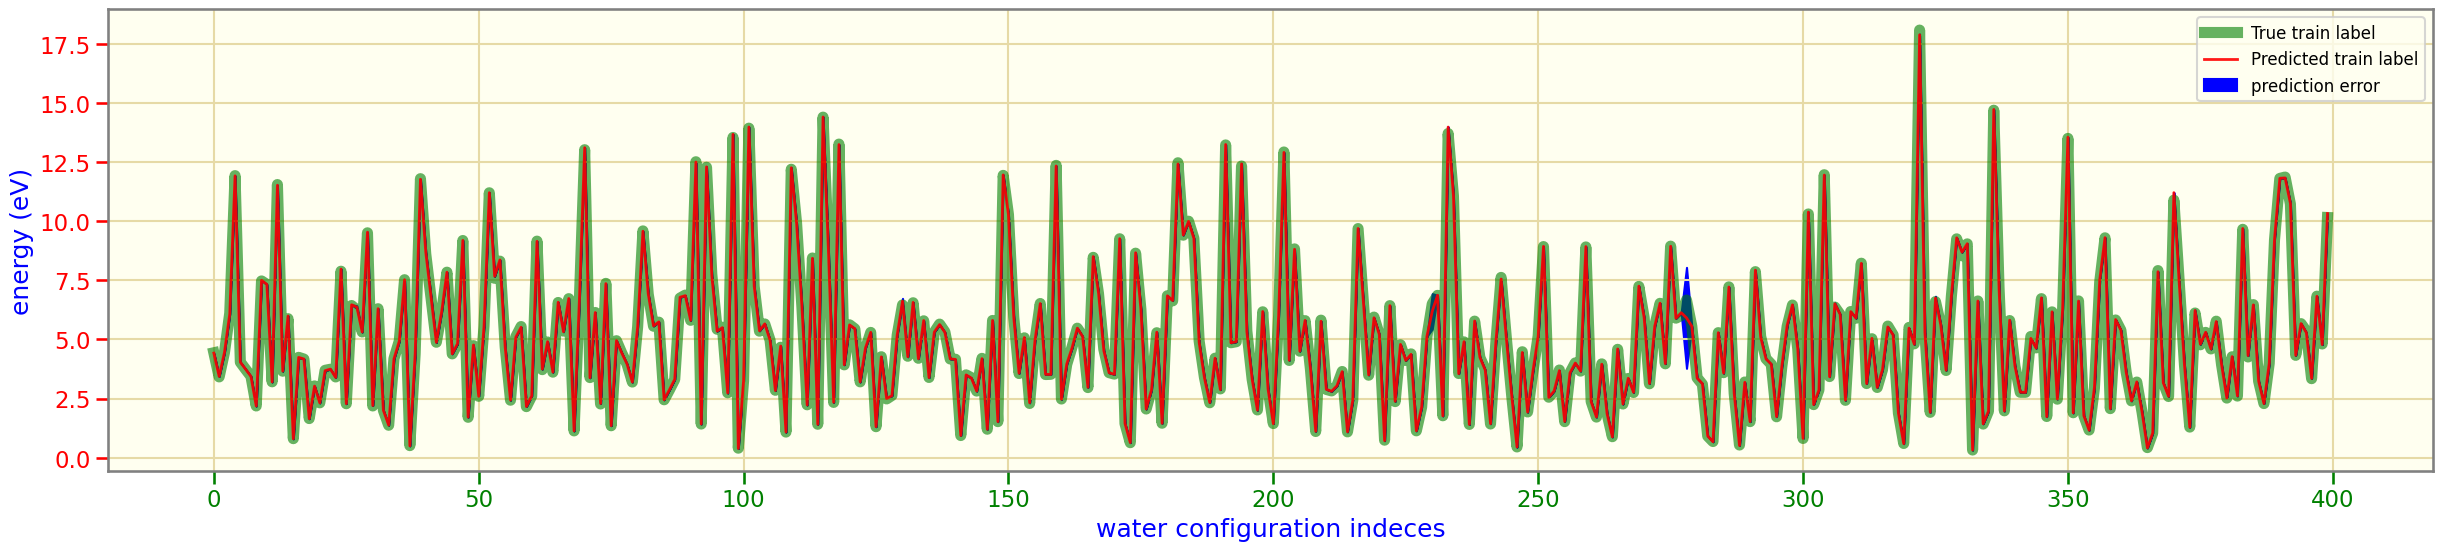

In [45]:
# number of test input is 2598
# number of train data is


fig, ax = plt.subplots(1, 1, figsize = (30, 6))

ax.plot(range(len(X_test[0:400])), y_test[0:400], color = 'green', label = 'True train label', alpha = 0.6, linewidth = 8)
ax.plot(range(len(X_test[0:400])), y_test_predict[:, 0][0:400], color = 'red', label = 'Predicted train label', alpha = 0.9, linewidth = 2)
ax.fill_between(range(len(X_test[0:400])), y_test_predict[:, 0][0:400] - y_test_error[:, 0][0:400], y_test_predict[:, 0][0:400] + y_test_error[:, 0][0:400], color= 'blue',
                alpha = 1, label = 'prediction error')

ax.grid()
ax.legend()
ax.set_xlabel('water configuration indeces')
ax.set_ylabel('energy (eV)')
plt.show()

### Question 3.a

**Briefly disucss how accurate the Gaussian Process water model is. How accurate is the error prediction?**

the model was pretty accurate, although we have used the 10% of the data for the training. definitely we will need more data.

### Question 3.b

We only used 10% of the data for training. By adapting the code above, starting from where we split the data into test and train set, fit further GP models with different fractions (10%, 20%, 40%, 80%) of training data - don't forget to optimise the likelihood. Summarise in a table how the root mean squared error (RMSE) changes. Write a short paragraph about the advantages and disadvantages of using more training data.

In [57]:
import pandas as pd

df = pd.DataFrame(columns=['train_size', 'RMSE'])

df['train_size'] = [0.1, 0.2, 0.4, 0.5, 0.7, 0.8, 0.95]

for i, train_size in enumerate(df.train_size):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=1 - train_size)
    X_train = np.array(X_train)
    y_train = np.array(y_train)[:, None]
    m = GPy.models.GPRegression(X_train, y_train, kernel, noise_var=1.)
    m.optimize_restarts(num_restarts=5)
    y_test_predict, y_test_error = m.predict(np.array(X_test))
    rmse = np.sqrt(np.mean((np.array(y_test)-y_test_predict[:,0])**2))
    print(train_size, rmse)
    df.iloc[i, 1] = rmse

df

 /usr/local/lib/python3.10/dist-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/5, f = -387.57243374232394
Optimization restart 2/5, f = -388.4784587041929
Optimization restart 3/5, f = -388.47847009734824
Optimization restart 4/5, f = -388.4783739413251
Optimization restart 5/5, f = -388.47832962505186
0.1 0.04777792878346599
Optimization restart 1/5, f = -760.1149374480347
Optimization restart 2/5, f = -749.5675789961206
Optimization restart 3/5, f = -749.5675303052076
Optimization restart 4/5, f = -749.5675576461656
Optimization restart 5/5, f = -749.5675642252313
0.2 0.027975150060442943
Optimization restart 1/5, f = -3785.177528154768
Optimization restart 2/5, f = -2677.4065062070194
Optimization restart 3/5, f = -3796.629422619787
Optimization restart 4/5, f = -3796.945829100686
Optimization restart 5/5, f = -2677.406627253238
0.4 0.2738071473930948
Optimization restart 1/5, f = -5531.618170571061
Optimization restart 2/5, f = -5534.800138498909
Optimization restart 3/5, f = -5534.335163630953
Optimization restart 4/5, f = -5534.616201

,train_size,RMSE
0,0.10,0.047778
1,0.20,0.027975
2,0.40,0.273807
3,0.50,0.034824
4,0.70,0.049784
5,0.80,0.007724
6,0.95,0.000239


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['train_size'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['train_size'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df, *['RMSE'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df, *['train_size', 'RMSE'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df, *['train_size', 'count()', 'RMSE'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['train_size'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_2, *['index'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_3, *['train_size'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_4, *['RMSE'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_5, *[[['index', 'train_size']]], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_6, *['index', 'RMSE'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_7, *['train_size', 'RMSE'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_8, *['index', 'count()', 'RMSE'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(_df_9, *['train_size', 'count()', 'RMSE'], **{})
chart

In [ ]:
df.to_csv('./train_size.csv')

In [31]:
# grid search for the training data sizes.


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import GPy


data_sizes = [0.1, 0.2, 0.4, 0.5, 0.7, 0.8, 0.95]


results_df = pd.DataFrame(columns=['Data Size', 'Optimized Noise Variance', 'Optimized Kernel Variance', 'Optimized Period'])

for data_size in data_sizes:

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=data_size, random_state=42)

    X_train = np.array(X_train)
    y_train = np.array(y_train)[:, None]


    kernel = GPy.kern.RBF(input_dim=3, variance=1., lengthscale=10.,ARD=True)


    m = GPy.models.GPRegression(X_train, y_train, kernel, noise_var=1.)
    m.optimize_restarts(num_restarts=5)


    optimized_noise_variance = m.Gaussian_noise.variance[0]
    optimized_kernel_variance = m.kern.variance[0]
    optimized_period = m.kern.lengthscale[0]
    y_pred, _ = m.predict(np.array(X_test))


    rmse = np.sqrt(mean_squared_error(y_test, y_pred))


    results_df = results_df.append({'Data Size': data_size,
                                    'Optimized Noise Variance': optimized_noise_variance,
                                    'Optimized Kernel Variance': optimized_kernel_variance,
                                    'Optimized lengthscale': optimized_period,
                                    'RMSE': rmse},
                                    ignore_index=True)



# Find the best configuration based on some criterion (e.g., lowest error)
best_config = results_df.loc[results_df['Optimized Noise Variance'].idxmin()]

# Print the best configuration
print("Best Configuration:")
print(best_config)

# Optionally, save the results to a CSV file
results_df.to_csv('optimized_results.csv', index=False)


Optimization restart 1/5, f = 6148.597393994176
Optimization restart 2/5, f = -13908.280587433193
Optimization restart 3/5, f = -13908.907832875866
Optimization restart 4/5, f = -13908.807541356495
Optimization restart 5/5, f = -13900.901710261318


 <ipython-input-31-4a336cabce43>:39: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Optimization restart 1/5, f = 5542.044192156917
Optimization restart 2/5, f = -11704.584610547596
Optimization restart 3/5, f = -11702.58206062417
Optimization restart 4/5, f = -11703.514000539783
Optimization restart 5/5, f = -11703.114972059353


 <ipython-input-31-4a336cabce43>:39: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Optimization restart 1/5, f = 1728.2017334183827
Optimization restart 2/5, f = -7547.554980209377
Optimization restart 3/5, f = -7548.960960698429
Optimization restart 4/5, f = -7547.538671886967
Optimization restart 5/5, f = -7547.829298418743


 <ipython-input-31-4a336cabce43>:39: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Optimization restart 1/5, f = 1488.2914285910965
Optimization restart 2/5, f = -5583.829110252389
Optimization restart 3/5, f = -5581.898402145294
Optimization restart 4/5, f = -5582.7035721344455
Optimization restart 5/5, f = -5582.266402514235


 <ipython-input-31-4a336cabce43>:39: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Optimization restart 1/5, f = -2341.1506658424782
Optimization restart 2/5, f = -2341.1539143168743
Optimization restart 3/5, f = -2341.1425406396547
Optimization restart 4/5, f = -2341.157676345043
Optimization restart 5/5, f = -2290.758950006124


 <ipython-input-31-4a336cabce43>:39: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Optimization restart 1/5, f = 826.0812840391757
Optimization restart 2/5, f = -1130.9502835263
Optimization restart 3/5, f = -1130.9509311437473
Optimization restart 4/5, f = 564.764042318795
Optimization restart 5/5, f = -1130.9508449010953


 <ipython-input-31-4a336cabce43>:39: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /usr/local/lib/python3.10/dist-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 1/5, f = -16.191339990153466
Optimization restart 2/5, f = -16.191340088788536
Optimization restart 3/5, f = -16.191339417077586
Optimization restart 4/5, f = -16.191340194307088
Optimization restart 5/5, f = -16.19133991519962
Best Configuration:
Data Size                             0.1
Optimized Noise Variance              0.0
Optimized Kernel Variance    22945.918048
Optimized Period                      NaN
Optimized lengthscale            0.368638
RMSE                             0.000235
Name: 0, dtype: object


 <ipython-input-31-4a336cabce43>:39: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [38]:
#results_df = results_df.drop(columns ='Optimized Period')
results_df

,Data Size,Optimized Noise Variance,Optimized Kernel Variance,Optimized lengthscale,RMSE
0,0.10,5.562685e-309,22945.918048,0.368638,0.000235
1,0.20,5.562685e-309,27833.835349,0.373874,0.045724
2,0.40,5.562685e-309,19795.317467,0.399213,0.030842
3,0.50,5.562685e-309,21470.974685,0.407021,0.065080
4,0.70,6.550745e-08,6627.234312,0.438853,0.071388
5,0.80,6.779101e-05,53714.263666,0.754916,0.031693
6,0.95,1.469734e-03,11730.096788,0.881307,0.098155


### Optimising the geometry of the water molecule, using a Gaussian Process energy model
In the following exercise, we will relax the Cartesian coordinates of a water molecule, in order to find the equilibrium geometry. We will use a wrapper function that generates the symmetrised descriptors and using the GP model, predicts the energy of the water molecule. For simplicity, we use the Nelder-Mead algorithm to find the minimum of the function, as it does not require access to the gradients.

In [28]:
# This is the wrapper function: Cartesian coordinates -> symmetrised descriptors -> GP
def GP_water_energy(x):
    _x = np.reshape(x, (3,3)) # Input is a flat array of x,y,z coordinates of three atoms.
    r1 = np.linalg.norm(_x[0] - _x[1]) # rOH1
    r2 = np.linalg.norm(_x[0] - _x[2]) # rOH2
    a = np.dot(_x[0] - _x[1],
               _x[0] - _x[2]) # dot product of the two OH vectors
    _xx = np.array([[(r1 + r2),
                     (r1 - r2)**2,
                     a]]) # symmetrised descriptor (see above)
    res = m.predict(_xx)[0][0][0] # GP prediction
    return res

We start from a not-too crazy initial condition, and relax the position of all atoms.

In [29]:
from scipy.optimize import minimize

x0 = np.array([0,0,0,       # Oxygen atom
               1.2,0,0,     # 1st hydrogen atom
               -0.5,0.7,0]) # 2nd hydrogen atom

res = minimize(GP_water_energy, # function to minimise
               x0,              # initial condition
               method='nelder-mead',
               options={"maxiter":1000, # number of iterations in the minimiser
                        "fatol":1e-6    # stopping criterion (tolerance)
                       })
# res.x contains the final configuration

In [93]:
res


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -0.0011741863563656807
             x: [-1.730e-04  3.300e-04  1.352e-03  9.562e-01  6.638e-04
                 -3.847e-03 -2.644e-01  9.196e-01  2.277e-04]
           nit: 407
          nfev: 958
 final_simplex: (array([[-1.730e-04,  3.300e-04, ...,  9.196e-01,
                         2.277e-04],
                       [-1.730e-04,  3.300e-04, ...,  9.196e-01,
                         2.277e-04],
                       ...,
                       [-1.730e-04,  3.300e-04, ...,  9.196e-01,
                         2.277e-04],
                       [-1.730e-04,  3.300e-04, ...,  9.196e-01,
                         2.277e-04]]), array([-1.174e-03, -1.174e-03, -1.174e-03, -1.174e-03,
                       -1.174e-03, -1.173e-03, -1.173e-03, -1.173e-03,
                       -1.173e-03, -1.173e-03]))

In [31]:
# We transform the Cartesian coordinates into bond lengths and the bond angle,
# for easier interpretation


_x = np.reshape(res.x, (3, 3))
r1 = np.linalg.norm(_x[0] - _x[1])
r2 = np.linalg.norm(_x[0] - _x[2])
a = np.dot(_x[0] - _x[1],_x[0] -_x[2])
print("r1 = {:.3f} A\nr2 = {:.3f} A\nangle = {:.1f} degrees".format(r1,r2,np.rad2deg(np.arccos(a))))

r1 = 0.956 A
r2 = 0.956 A
angle = 104.6 degrees


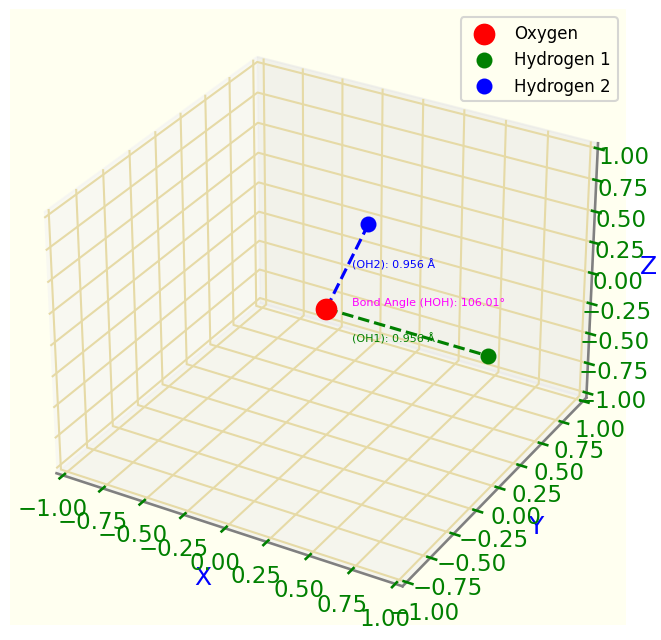

In [32]:
import plotly.graph_objects as go
import webbrowser



fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

oxygen = _x[0]
hydrogen1 = _x[1]
hydrogen2 = _x[2]

bond_length_oh1 = r1
bond_length_oh2 = r2

cos_theta = a/ (bond_length_oh1 * bond_length_oh2)
bond_angle = np.arccos(cos_theta) * (180.0 / np.pi)


ax.scatter(*oxygen, c = 'r', s = 200, label = 'Oxygen')
ax.scatter(*hydrogen1, c = 'g', s = 100, label = 'Hydrogen 1' )
ax.scatter(*hydrogen2, c = 'b', s = 100, label = 'Hydrogen 2')


# the bonds:
ax.plot([oxygen[0], hydrogen1[0]], [oxygen[1], hydrogen1[1]], [oxygen[2], hydrogen1[2]], 'g--')
ax.plot([oxygen[0], hydrogen2[0]], [oxygen[1], hydrogen2[1]], [oxygen[2], hydrogen2[2]], 'b--')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


ax.text(0.1, 0.1, -0.3, f'(OH1): {bond_length_oh1:.3f} Å', fontsize=8, color = 'g')
ax.text(0.1, 0.1, 0.3, f'(OH2): {bond_length_oh2:.3f} Å', fontsize=8, color = 'b')
ax.text(0.1, 0.1, 0.0, f'Bond Angle (HOH): {bond_angle:.2f}°', fontsize=8, color = 'magenta')
b


ax.set_xlim(-1.0, 1.0)
ax.set_ylim(-1.0, 1.0)
ax.set_zlim(-1.0, 1.0)


ax.legend()


plt.show()





### Question 4

**Inspect the resulting water geometry. How realistic is it? Compare the geometrical parameters to literature (experimental and/or theoretical) values.**

based on the measurement conducted by G Császár et al, The mass-independent [Born-Oppenheimer (BO)] equilibrium bond length and bond angle on the ground electronic state PES of water is r(e) (BO)=0.957 82 A and theta e (BO)=104.48(5) degrees , respectively. The bond_lengths estimations are very percise; however, the theta estimation sufferes from inaccuracy.

## different kernels:
Try different kernels `GPy.kern.` in the Gaussian Process regression.

In [57]:
# grid search for the training data sizes.


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import GPy


data_sizes = [0.1, 0.2, 0.4, 0.5, 0.7, 0.8, 0.95]


results_df = pd.DataFrame(columns=['Data Size', 'Optimized Noise Variance', 'Optimized Kernel Variance', 'Optimized Period'])

for data_size in data_sizes:

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=data_size, random_state=42)

    X_train = np.array(X_train)
    y_train = np.array(y_train)[:, None]


    kernel = GPy.kern.Exponential(input_dim=3, variance=1.0, lengthscale=1.0)


    m = GPy.models.GPRegression(X_train, y_train, kernel, noise_var=1.)
    m.optimize_restarts(num_restarts=5)


    optimized_noise_variance = m.Gaussian_noise.variance[0]
    optimized_kernel_variance = m.kern.variance[0]
    optimized_period = m.kern.lengthscale[0]
    y_pred, _ = m.predict(np.array(X_test))


    rmse = np.sqrt(mean_squared_error(y_test, y_pred))


    results_df = results_df.append({'Data Size': data_size,
                                    'Optimized Noise Variance': optimized_noise_variance,
                                    'Optimized Kernel Variance': optimized_kernel_variance,
                                    'Optimized Lengthscale': optimized_period,
                                    'RMSE': rmse},
                                    ignore_index=True)



# Find the best configuration based on some criterion (e.g., lowest error)
best_config = results_df.loc[results_df['Optimized Noise Variance'].idxmin()]

# Print the best configuration
print("Best Configuration:")
print(best_config)

# Optionally, save the results to a CSV file
results_df.to_csv('optimized_results_EXP.csv', index=False)

Optimization restart 1/5, f = 101.0918822627732
Optimization restart 2/5, f = 101.0918843903396
Optimization restart 3/5, f = 101.09188092554905
Optimization restart 4/5, f = 101.09188098828463
Optimization restart 5/5, f = 101.09188125552714


 <ipython-input-57-f7177b158e72>:39: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Optimization restart 1/5, f = 251.33874931925834
Optimization restart 2/5, f = 251.33875102354023
Optimization restart 3/5, f = 251.33874931273908
Optimization restart 4/5, f = 251.33874933035418
Optimization restart 5/5, f = 251.3387671116452


 <ipython-input-57-f7177b158e72>:39: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Optimization restart 1/5, f = 485.6130852648239
Optimization restart 2/5, f = 485.61309121976683
Optimization restart 3/5, f = 485.6130869220915
Optimization restart 4/5, f = 485.6130858696404
Optimization restart 5/5, f = 485.6130867858444


 <ipython-input-57-f7177b158e72>:39: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Optimization restart 1/5, f = 563.9061399273535
Optimization restart 2/5, f = 563.906138510805
Optimization restart 3/5, f = 563.9061383911114
Optimization restart 4/5, f = 563.9061420788687
Optimization restart 5/5, f = 563.9061633405757


 <ipython-input-57-f7177b158e72>:39: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Optimization restart 1/5, f = 608.2978179458403
Optimization restart 2/5, f = 608.2978194420507
Optimization restart 3/5, f = 608.2978171657135
Optimization restart 4/5, f = 608.2978366311212
Optimization restart 5/5, f = 608.2978201134481


 <ipython-input-57-f7177b158e72>:39: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Optimization restart 1/5, f = 506.85792254298855
Optimization restart 2/5, f = 506.8579225431564
Optimization restart 3/5, f = 506.8579225421962
Optimization restart 4/5, f = 506.8579225424091
Optimization restart 5/5, f = 506.8579226094379


 <ipython-input-57-f7177b158e72>:39: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Optimization restart 1/5, f = 225.02510042181842
Optimization restart 2/5, f = 225.0251004306926
Optimization restart 3/5, f = 225.02510038847578
Optimization restart 4/5, f = 225.02510037957975
Optimization restart 5/5, f = 225.02510038150794
Best Configuration:
Data Size                           0.2
Optimized Noise Variance            0.0
Optimized Kernel Variance    535.943885
Optimized Period                    NaN
Optimized Lengthscale        522.131189
RMSE                           0.100682
Name: 1, dtype: object


 <ipython-input-57-f7177b158e72>:39: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [59]:
results_df.drop(columns = 'Optimized Period')
results_df

,Data Size,Optimized Noise Variance,Optimized Kernel Variance,Optimized Period,Optimized Lengthscale,RMSE
0,0.10,3.966275e-150,543.941475,NaN,581.958201,0.080987
1,0.20,1.347171e-192,535.943885,NaN,522.131189,0.100682
2,0.40,1.936839e-46,508.252833,NaN,397.502857,0.127803
3,0.50,1.290222e-90,498.420791,NaN,335.854374,0.141563
4,0.70,2.243710e-108,458.685878,NaN,209.125833,0.214021
5,0.80,3.734601e-137,394.782523,NaN,150.657129,0.356509
6,0.95,6.869132e-58,202.123022,NaN,36.719272,0.807312


## Part 2
### Inferring a pair interaction model based on total energy information

For certain types of atomic systems, the total, inherently many-body interaction energy may be approximated by pair interaction terms: $E(\mathbf{r}_1, \mathbf{r}_2, \ldots \mathbf{r}_N) \approx \sum^N_{i<j} E_2(r_{ij})$, where the system consists of $N$ atoms with Cartesian coordinates $\mathbf{r}_1, \mathbf{r}_2, \ldots \mathbf{r}_N$. $E_2$ is a function of interatomic distances $r_{ij}$. Example where this works well are noble gases or certain types of metals.

In this part of the workshop, we will study a toy problem, where the total interaction energy consists explicitly of two-body terms, and the aim of the workshop is to recover the original model. We will use configurations of clusters of 12-19 atoms, and the interaction energy (the underlying function we are trying to fit) will be the Lennard-Jones model for the total energy

$$
E^{LJ}(r_{ij}) = 4\left(\frac1{r_{ij}^{12}} - \frac1{r_{ij}^6} \right)
$$

* $E^{LJ}(r_{ij})$ : is the potential energy between two particles at a distance r.
* $\frac {1}{{r_{ij}}^{12}}$ (The attractive term): which represents long-range attractions due to van der waals forces.
* $\frac {1}{{r_{ij}^6}}$ (The repulsive term): which represent the repulsion due to overlapping electron clouds.




To calculate the total energy of a cluster of atoms using the Lennard-Jones potential, you would sum the pairwise interactions between all pairs of atoms in the cluster. The total energy is the sum of all these pairwise contributions. This approach is commonly used in molecular dynamics simulations to model the behavior of clusters of atoms or molecules.

It's worth noting that while the Lennard-Jones potential is a useful and simple model, it's a highly simplified representation of atomic interactions and may not accurately describe all types of molecular interactions. More complex force fields and potential energy functions are often used in realistic simulations of molecular systems.

In [39]:
# We load the cluster configurations
cluster_trajectory = read("clusters.xyz", index=":")
print(len(cluster_trajectory[345]), len( cluster_trajectory[1])) # the clusters consist of 12 to 19 atoms

13 19


In [40]:

nglview.show_asetraj(cluster_trajectory)

NGLWidget(max_frame=399)

In [41]:
cluster_trajectory[0]

Atoms(symbols='Ar19', pbc=False)


The term "Ar19 cluster atoms" refers to a cluster of 19 argon (Ar) atoms. In this context:

* **Ar**: This is the chemical symbol for argon, which is a **noble gas** and one of the chemical elements on the periodic table (atomic number 18). Argon is a colorless, odorless, and inert gas that is commonly found in the Earth's atmosphere. It is often used in various scientific and industrial applications.

* **19 cluster atoms**: This specifies the number of argon atoms in the cluster. In the context of cluster chemistry and physics, clusters are assemblies of a small number of atoms or molecules (typically ranging from a few to several hundred) that are held together by weak intermolecular forces or chemical bonds. Studying the properties of such clusters can provide insights into the behavior of matter at the nanoscale.

"Ar19 cluster atoms" would refer to a specific arrangement of 19 argon atoms, and the properties of such a cluster could be of interest in the study of cluster physics or chemistry. These clusters may exhibit unique properties, such as electronic structure or reactivity, that differ from those of individual atoms or larger bulk materials.

In [42]:
# For each cluster, we calculate the total energy and collect it in cluster_energy
# here we don't implement the QM potential energy that we did in the last approach, but instaed we use the Lennard Jones
#model which is a simple pair model.
from ase.calculators.lj import LennardJones
p = LennardJones()

cluster_energy = [] # 400 clusters, 400 energies
for a in cluster_trajectory:
    a.set_calculator(p)
    cluster_energy.append(a.get_potential_energy()) # the true labels are calculated with lennard jonnes
    # these energis are for clusters

In [43]:
# We split the data in train and test set.


from sklearn.model_selection import train_test_split

cluster_train, cluster_test, cluster_energy_train, cluster_energy_test = train_test_split(
    cluster_trajectory, cluster_energy, test_size=0.4)

The model we use for the total energy is

$$E_{cluster} = \sum_{i<j} {\mathcal GP}(r_{ij}).$$

* $E_{cluster}$ : is the energy for a single cluster.
* ${\mathcal GP}(r_{ij})$ : is the gaussian process prediction calculation (prediction) of the pair-wise energies.

To fit the GP, we need to obtain all pair-wise distances in each configuration.
we need to create this sum Gaussian regression to predict the energy for each cluster, rather than the a single interaction.

In [44]:
from ase.neighborlist import neighbor_list

def get_distances(atoms_array,cutoff=3.0):
    distances = []
    for a in atoms_array:
        i, j, d = neighbor_list('ijd', a, cutoff)
        d = d[i < j]  # We exclude duplicates
        distances.append(d)
    return distances # List of arrays of distances for each cluster

In [45]:
distances_train = get_distances(cluster_train)
distances_test = get_distances(cluster_test)
distances_train[0] # for the first cluster.

array([1.51744079, 2.00580364, 2.31991853, 1.04078168, 2.14416905,
       2.07667042, 1.0129415 , 1.3814536 , 1.27013179, 1.66555014,
       1.16489483, 1.79439475, 1.21632187, 2.34045892, 1.77191475,
       1.06431268, 1.29733875, 1.93244619, 1.2336981 , 1.09544133,
       1.70181903, 2.17599656, 1.70463817, 1.08346566, 2.27724689,
       2.23482857, 1.22588674, 2.16392733, 1.84208732, 2.91770516,
       2.49828982, 1.67820066, 2.12577776, 2.81593312, 1.18056922,
       2.03534834, 1.07134131, 1.12418192, 2.14999355, 2.32779884,
       1.29112766, 1.43317637, 1.35177287, 2.26259943, 1.59367517,
       1.9200602 , 2.50088134, 2.68086475, 1.28700562, 2.08490954,
       2.28650111, 2.18699313, 2.27112531, 1.45763673, 1.86663263,
       1.17095745, 1.14183271, 1.86261549, 1.12766997, 2.43540129,
       1.44460842, 2.07458397, 2.19698412, 1.15220757, 2.15959415,
       1.13732753, 2.4195137 , 1.5491214 , 1.85137187, 1.93850993,
       2.44704738, 1.16477694, 2.03573662, 1.34715226, 2.10565

The target data (cluster) is the sum of Gaussian Process models (for each interactions). We need to find the covariance of total energies (for a cluster): if the covariance of two pair interactions terms is $k(r,r')$, the covariance of two total energies of two configurations (clusters) $A$ and $B$ is the sum of covariance functions:

$$\langle E_A E_B \rangle = \sum_{ij \in A, i'j' \in B} k(r_{ij},r_{i'j'})$$

the covariance between two total enegies for two clusters A and B, is the sum of correlation between the distances in cluster A and B.


The following class implements this idea.

In [46]:
from scipy.spatial.distance import cdist

class SumGP:
    """Class implementing a sum Gaussian Process"""

    def __init__(self, length_scale=1.0, function_range=1.0, error=0.1):
        """Initialise the class with the GP hyperparameters"""
        self.length_scale = length_scale
        self.function_range = function_range
        self.error = error

    def update_covariance(self):
        """Update the covariance matrix"""
        self.covariance = self.sum_covariance(self.training_data,self.training_data)
        self.covariance += np.eye(len(self.covariance))*self.error**2

    def update_weights(self):
        """Update the GP model weights"""
        self.weights = np.linalg.solve(self.covariance,self.training_target)

    def update_gp(self):
        """Update the covariance and the GP model weights"""
        self.update_covariance()
        self.update_weights()

    def set_training_data(self,distances,energies):
        """Add training data and perform the fit"""
        self.training_data = distances
        self.training_target = energies
        self.update_gp()

    def set_parameters(self,length_scale=None,function_range=None,error=None):
        """Update GP hyperparameters"""
        changed = False
        if length_scale is not None:
            self.length_scale = length_scale
            changed = True
        if function_range is not None:
            self.function_range = function_range
            changed = True
        if error is not None:
            self.error = error
            changed = True
        if changed:
            self.update_gp()

    def predict(self,distances, do_variance=False, do_covariance=False):
        """
        Predicts total energy for a set of pairwise distances,
        optionally with variances
        """
        k = self.sum_covariance(distances,self.training_data)
        mean = np.dot(k,self.weights)
        res = {"mean":mean}
        if do_variance:
            variance = []
            for _d,_k in zip(distances,k):
                variance.append(self.error**2+
                    self.sum_covariance([_d],[_d])[0,0] -
                           np.dot(_k, np.linalg.solve(self.covariance,_k))
                )
            res["variance"] = variance

        if do_covariance:
            covariance = self.sum_covariance(distances,distances)
            res["covariance"] = ( np.eye(len(distances))*self.error**2 +
                                 covariance - np.dot(k,np.linalg.solve(self.covariance,k.T)) )

        return res

    def sum_covariance(self, d1, d2):
        """Sum covariance function"""
        covariance = []
        for i, _d1 in enumerate(d1):
            _c_row = []
            for j, _d2 in enumerate(d2):
                distance_matrix = cdist(
                    np.array(_d1)[:,None],
                    np.array(_d2)[:,None],
                    'euclidean')

                _c = np.sum(self.function_range**2*np.exp(
                            -0.5*distance_matrix**2/self.length_scale**2)) # Kernel for <E_A E_B>
                _c_row.append(_c)
            covariance.append(_c_row)
        covariance = np.array(covariance)
        return covariance


In [47]:
distances_train[0]

array([1.51744079, 2.00580364, 2.31991853, 1.04078168, 2.14416905,
       2.07667042, 1.0129415 , 1.3814536 , 1.27013179, 1.66555014,
       1.16489483, 1.79439475, 1.21632187, 2.34045892, 1.77191475,
       1.06431268, 1.29733875, 1.93244619, 1.2336981 , 1.09544133,
       1.70181903, 2.17599656, 1.70463817, 1.08346566, 2.27724689,
       2.23482857, 1.22588674, 2.16392733, 1.84208732, 2.91770516,
       2.49828982, 1.67820066, 2.12577776, 2.81593312, 1.18056922,
       2.03534834, 1.07134131, 1.12418192, 2.14999355, 2.32779884,
       1.29112766, 1.43317637, 1.35177287, 2.26259943, 1.59367517,
       1.9200602 , 2.50088134, 2.68086475, 1.28700562, 2.08490954,
       2.28650111, 2.18699313, 2.27112531, 1.45763673, 1.86663263,
       1.17095745, 1.14183271, 1.86261549, 1.12766997, 2.43540129,
       1.44460842, 2.07458397, 2.19698412, 1.15220757, 2.15959415,
       1.13732753, 2.4195137 , 1.5491214 , 1.85137187, 1.93850993,
       2.44704738, 1.16477694, 2.03573662, 1.34715226, 2.10565

In [48]:
# how cdist works ?



points_set1 = np.array([[1, 2], [3, 4], [5, 6]])
points_set2 = np.array([[2, 2], [4, 4], [6, 6]])

# Calculate pairwise Euclidean distances
distances = cdist(points_set1, points_set2, metric='euclidean')

print((1)**2*np.exp(
                            -0.5*distances**2/(1)**2))

[[6.06530660e-01 1.50343919e-03 1.25015287e-09]
 [8.20849986e-02 6.06530660e-01 1.50343919e-03]
 [3.72665317e-06 8.20849986e-02 6.06530660e-01]]


In [49]:
# how cdist works ?


# Calculate pairwise Euclidean distances for a single cluster with itself.
distances = cdist(distances_train[0][:, None], distances_train[0][:, None], metric='euclidean')

distances

array([[0.        , 0.48836284, 0.80247774, ..., 0.07125551, 0.03211157,
        0.31531494],
       [0.48836284, 0.        , 0.3141149 , ..., 0.55961836, 0.45625127,
        0.80367779],
       [0.80247774, 0.3141149 , 0.        , ..., 0.87373326, 0.77036617,
        1.11779268],
       ...,
       [0.07125551, 0.55961836, 0.87373326, ..., 0.        , 0.10336708,
        0.24405943],
       [0.03211157, 0.45625127, 0.77036617, ..., 0.10336708, 0.        ,
        0.34742651],
       [0.31531494, 0.80367779, 1.11779268, ..., 0.24405943, 0.34742651,
        0.        ]])

We now use this class to build a Gaussian Process regression model

In [50]:
# Initialise the GP with hyperparameters
sum_gp = SumGP(length_scale=0.25, error=0.5, function_range=5.0)

In [51]:
# Add data and fit the model
sum_gp.set_training_data(distances_train, cluster_energy_train)

### Optimising the hyperparameters
To find the optimal hyperparameters (`length_scale`, `error` and `function_range`) we can try maximising the likelihood of the model:

$$
\log L = -\frac{1}{2} \mathbf{y}^T \mathbf{K}^{-1} \mathbf{y} - \frac{1}{2} \log |\mathbf{K}| - \frac{n}{2} \log 2 \pi$$

Remember, the two main components of this expression balance the goodness of the fit (first term) and the complexity of the model (second term).


* $- \frac {1}{2} log{∣K∣} :$ This term represents the complexity penalty of the model. It quantifies the complexity of the Gaussian process and encourages a simpler model when the determinant of the covariance matrix (
$K$) is large. A simpler model generally corresponds to a smoother and less wiggly regression function.
* $ − \frac{n}{2}log{2π} :$ This term is a constant that depends on the number of data points (
n) and ensures that the log-likelihood is properly scaled.

### Question 5.a

Implement a log likelihood function for the `SumGP` class using the template provided below. Use the numpy function [np.linalg.slogdet](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.slogdet.html) to compute the log of the determinent of the covariance matrix. For the first term of the log likelihood expression, notice that $\mathbf{K}^{-1} \mathbf{y} = \mathbf{w}$, the fitted weights of the model, stored as `self.weights` in the `SumGP` class.


In [52]:
def get_likelihood(self):
    """Calculate GP likelihood"""

    res = 0.0
    ### BEGIN SOLUTION
    sign, logdet = np.linalg.slogdet(self.covariance)
    res = (-0.5*np.dot(self.training_target, self.weights)
     -0.5*logdet +
     -0.5*len(self.training_target)*np.log(2*np.pi))
    ### END SOLUTION

    return res

SumGP.get_likelihood = get_likelihood

### Question 5.b

Compute the log likelihood as a function of the `length_scale` hyperparameter. Plot the results, and determine the optimal parameter, given the other two hyperparameters remain fixed. [10 marks]

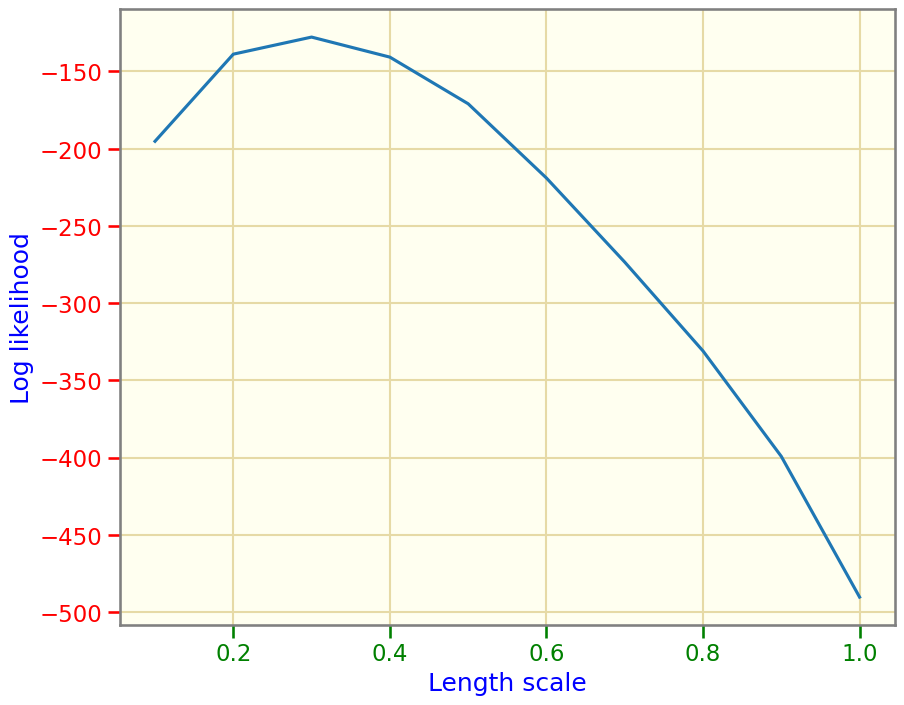

In [56]:
sum_gp = SumGP(length_scale=0.25,error=0.5,function_range=5.0)
sum_gp.set_training_data(distances_train,cluster_energy_train)

plt.style.use(custom_style_gold)
length_scale_array = np.linspace(0.1, 1.0, 10)
likelihood_array = []
for _l in length_scale_array:
    sum_gp.set_parameters(length_scale=_l)
    likelihood_array.append(sum_gp.get_likelihood())

plt.plot(length_scale_array,likelihood_array)
plt.xlabel('Length scale')
plt.ylabel('Log likelihood')
plt.grid(True)

### Question 6.a

Set the `length_scale` hyperparameter to the optimal value you found above, and plot the two-body interatomic potential model as a function of interatomic distances, with error bars, and compare it with the known solution, the Lennard-Jones model. You need to set the range of distances where you want to inspect the model - start from short distances and go beyond the cutoff (3.0) we used.

Here is some sample code to do predictions to get you started

```python
# Predict pair interaction energies using the GP model
r_min = ...
r_max = ...
r_test = np.linspace(r_min,r_max)[:,None]
test_gp = sum_gp.predict(r_test,do_variance=True,do_covariance=True)
e_test_gp = test_gp["mean"]
v_test_gp = test_gp["variance"]
c_test_gp = test_gp["covariance"]
```


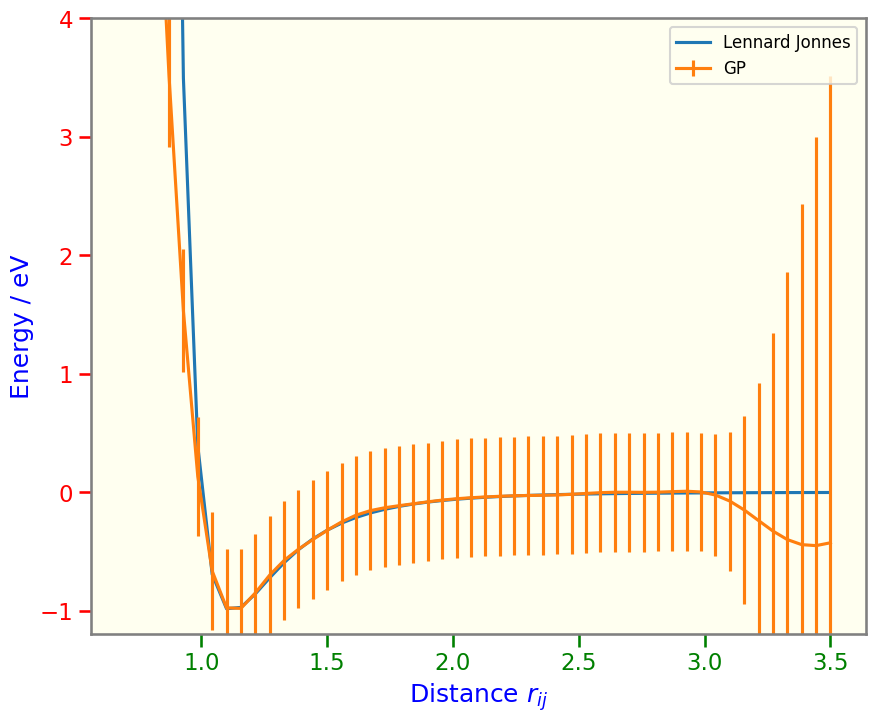

In [60]:
plt.style.use(custom_style_gold)
sum_gp.set_parameters(length_scale=0.3)
r_min = 0.7
r_max = 3.5

r_test = np.linspace(r_min,r_max)[:,None]

# Lennard-Jones model - the target of the GP model
e_test_lj = 4*(1/r_test**12-1/r_test**6)

# Predict pair interaction energies using the GP model
test_gp = sum_gp.predict(r_test,do_variance=True,do_covariance=True)
e_test_gp = test_gp["mean"]
v_test_gp = test_gp["variance"]
c_test_gp = test_gp["covariance"]

# Plot the results
plt.plot(r_test,e_test_lj, label = 'Lennard Jonnes')
plt.errorbar(r_test,e_test_gp,yerr=np.sqrt(v_test_gp), label = 'GP')
plt.ylim([-1.2,4])
plt.xlabel('Distance $r_{ij}$')
plt.ylabel('Energy / eV')
plt.legend()

### Question 6.b

Inspect the predicted error. Identify the domains where the predicted error is large - what is the reason for this? [10 marks]

YOUR ANSWER HERE

### Question 6.c

In the code cell below, using the `np.random.multivariate_normal` function (as seen in the lecture), with `test_gp["mean"]` as the mean and `test_gp["covariance"]` as the covariance, where `test_gp` is the result of calling `sum_gp.predict()`), draw samples from the posterior. Plot the results together with the known target function (Lennard-Jones pairwise interactions). Looking at these samples, how appropriate is our prior (squared exponential kernel)? Which feature of the Lennard-Jones model is causing problems? [5 marks code + 5 marks discussion]

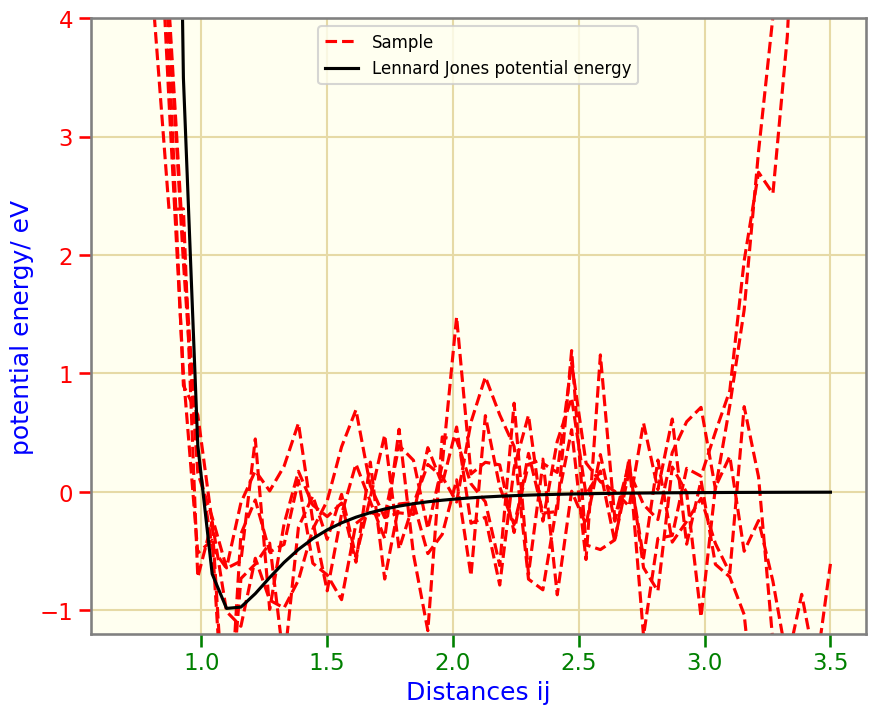

In [66]:
N_sample = 5

for i in range(N_sample):
    s_test_gp = np.random.multivariate_normal(e_test_gp, c_test_gp)
    if i != 4:
      plt.plot(r_test, s_test_gp, 'r--')
    else:
      plt.plot(r_test, s_test_gp, 'r--', label = 'Sample')

plt.plot(r_test,e_test_lj,"k-", label = 'Lennard Jones potential energy')
plt.ylim([-1.2,4])
plt.legend()
plt.ylabel('potential energy/ eV')
plt.xlabel('Distances ij')
plt.grid(True)
plt.show()

YOUR ANSWER HERE

### Question 7

Adapt the code used above to predict GP energies (i.e., using `sum_gp.predict()`), evaluate the GP model on the test set `distances_test` we generated by splitting the original data set. Plot the correlation of the target energy and the prediction, with error bars. [5 marks]

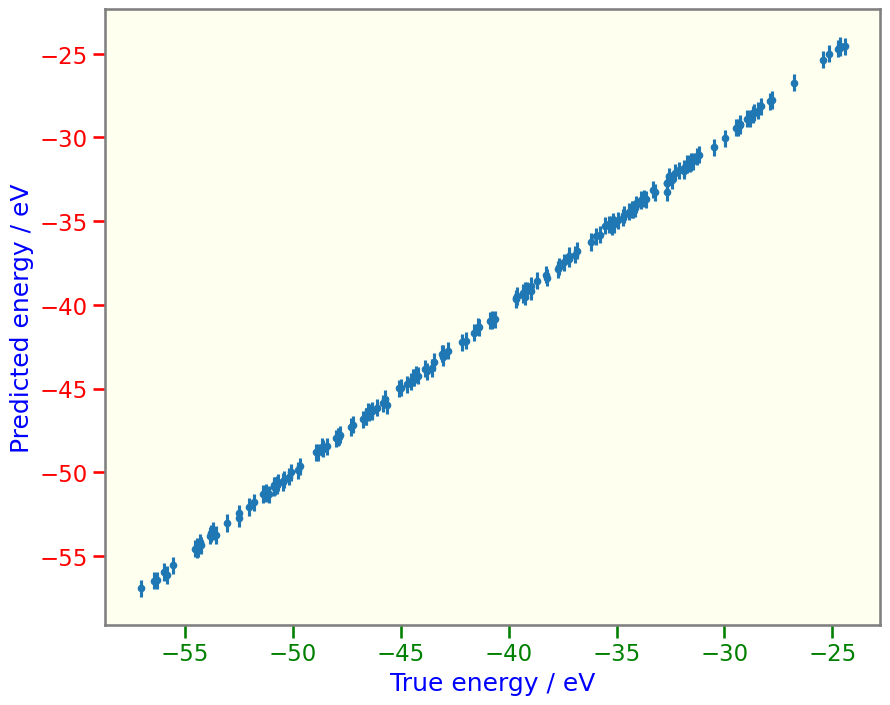

In [47]:
cluster_gp = sum_gp.predict(distances_test, do_variance=True)
cluster_energy_predict = cluster_gp["mean"]
cluster_energy_variance = cluster_gp["variance"]

plt.errorbar(cluster_energy_test, cluster_energy_predict,
             yerr=np.sqrt(cluster_energy_variance),fmt=".")
plt.xlabel('True energy / eV')
plt.ylabel('Predicted energy / eV');

 /usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
 /usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
 /usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
 /usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning:The optimal value found for dimension 0 of p

 /usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.


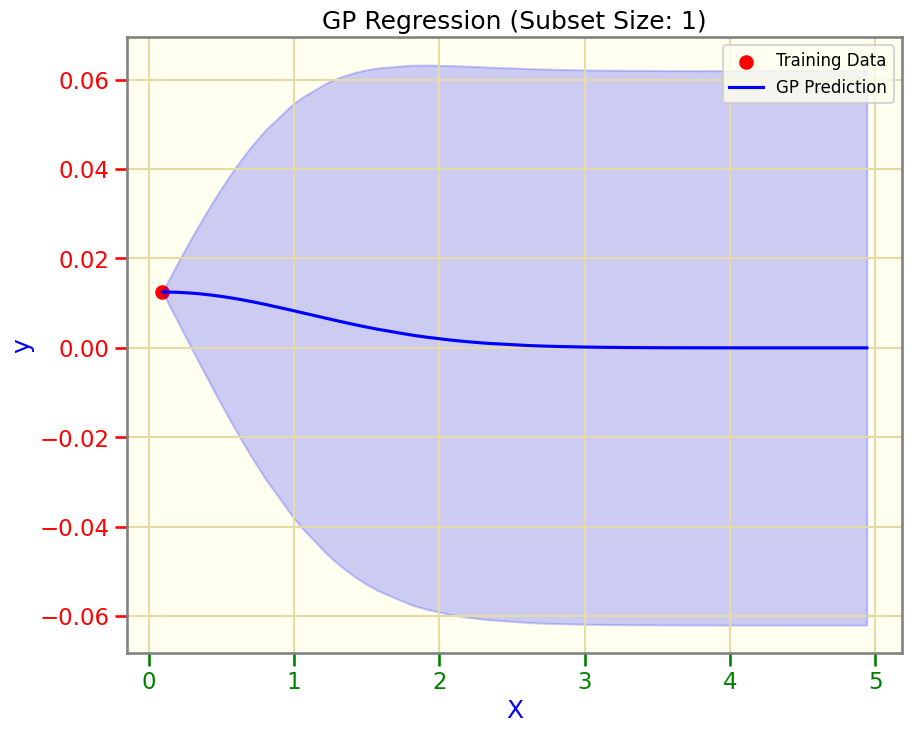

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


np.random.seed(0)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.1, X.shape[0])


kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))


subset_size = 5
subset_size = max(subset_size, 1)
initial_X = X[:subset_size]
initial_y = y[:subset_size]
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(initial_X, initial_y)


def animate_gp_fit(i):
    plt.cla()


    subset_size = max(int(i * 0.1 * len(X)), 1)


    gp.fit(X[:subset_size], y[:subset_size])

    # Predict mean and standard deviation
    y_pred, sigma = gp.predict(X, return_std=True)

    # Plot training data
    plt.scatter(X[:subset_size], y[:subset_size], color='r', label='Training Data')

    # Plot GP regression
    plt.plot(X, y_pred, 'b-', label='GP Prediction')


    plt.fill_between(X.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.2, color='blue')

    plt.title(f'GP Regression (Subset Size: {subset_size})')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)


fig, ax = plt.subplots(figsize=(10, 8))
ani = FuncAnimation(fig, animate_gp_fit, frames=10, repeat=True)
ani.save('gp_regression_animation.gif', writer='pillow', fps=2)


HTML(ani.to_jshtml())


### Extension  question (not assessed)

Instead of the squared exponential kernel, implement another kernel (e.g. the exponential kernel $k(r,r') = \exp ( |r-r'| / l)$ or any other) in the `SumGP` class. Does it represent a better prior than the squared exponential kernel?